In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

**1. DATA LOADING AND INITIAL EXPLORATION**

In [2]:
df = pd.read_csv('/content/midfielders_only_2023.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
df.head()

print("\nBasic Statistics:")
df.describe()

print("\nMissing Values:")
df.isnull().sum()

Dataset Shape: (1922, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   name                                  1922 non-null   object 
 1   country_of_citizenship                1922 non-null   object 
 2   position                              1922 non-null   object 
 3   foot                                  1922 non-null   object 
 4   height_in_cm                          1922 non-null   float64
 5   current_club_domestic_competition_id  1922 non-null   object 
 6   current_club_name                     1922 non-null   object 
 7   market_value_in_eur                   1922 non-null   float64
 8   yellow_cards                          1922 non-null   int64  
 9   red_cards                             1922 non-null   int64  
 10  goals                                 1922 

,0
name,0
country_of_citizenship,0
position,0
foot,0
height_in_cm,0
current_club_domestic_competition_id,0
current_club_name,0
market_value_in_eur,0
yellow_cards,0
red_cards,0


**2. DATA CLEANING AND PREPROCESSING**

In [3]:
df = df.dropna()  # or use df.fillna() based on your preference

# Create performance metrics per 90 minutes (assuming minutes_played is total)
df['goals_per_90'] = (df['goals'] / df['minutes_played']) * 90
df['assists_per_90'] = (df['assists'] / df['minutes_played']) * 90
df['cards_per_90'] = ((df['yellow_cards'] + df['red_cards'] * 2) / df['minutes_played']) * 90

# Create experience and market value categories
df['experience_level'] = pd.cut(df['minutes_played'],
                               bins=[0, 1000, 2500, 4000, float('inf')],
                               labels=['Low', 'Medium', 'High', 'Very High'])

df['market_value_tier'] = pd.cut(df['market_value_in_eur'],
                                bins=[0, 20000000, 50000000, 100000000, float('inf')],
                                labels=['Budget', 'Mid-tier', 'High-value', 'Elite'])

print("\nNew features created:")
print(f"Goals per 90: {df['goals_per_90'].describe()}")
print(f"Assists per 90: {df['assists_per_90'].describe()}")
print(f"Cards per 90: {df['cards_per_90'].describe()}")


New features created:
Goals per 90: count    1922.000000
mean        0.119720
std         0.425861
min         0.000000
25%         0.000000
50%         0.052448
75%         0.152329
max        15.000000
Name: goals_per_90, dtype: float64
Assists per 90: count    1922.000000
mean        0.104844
std         0.183557
min         0.000000
25%         0.000000
50%         0.056604
75%         0.158591
max         4.736842
Name: assists_per_90, dtype: float64
Cards per 90: count    1922.000000
mean        0.337661
std         2.322624
min         0.000000
25%         0.091504
50%         0.209373
75%         0.344425
max        90.000000
Name: cards_per_90, dtype: float64


**3. EXPLORATORY DATA ANALYSIS**

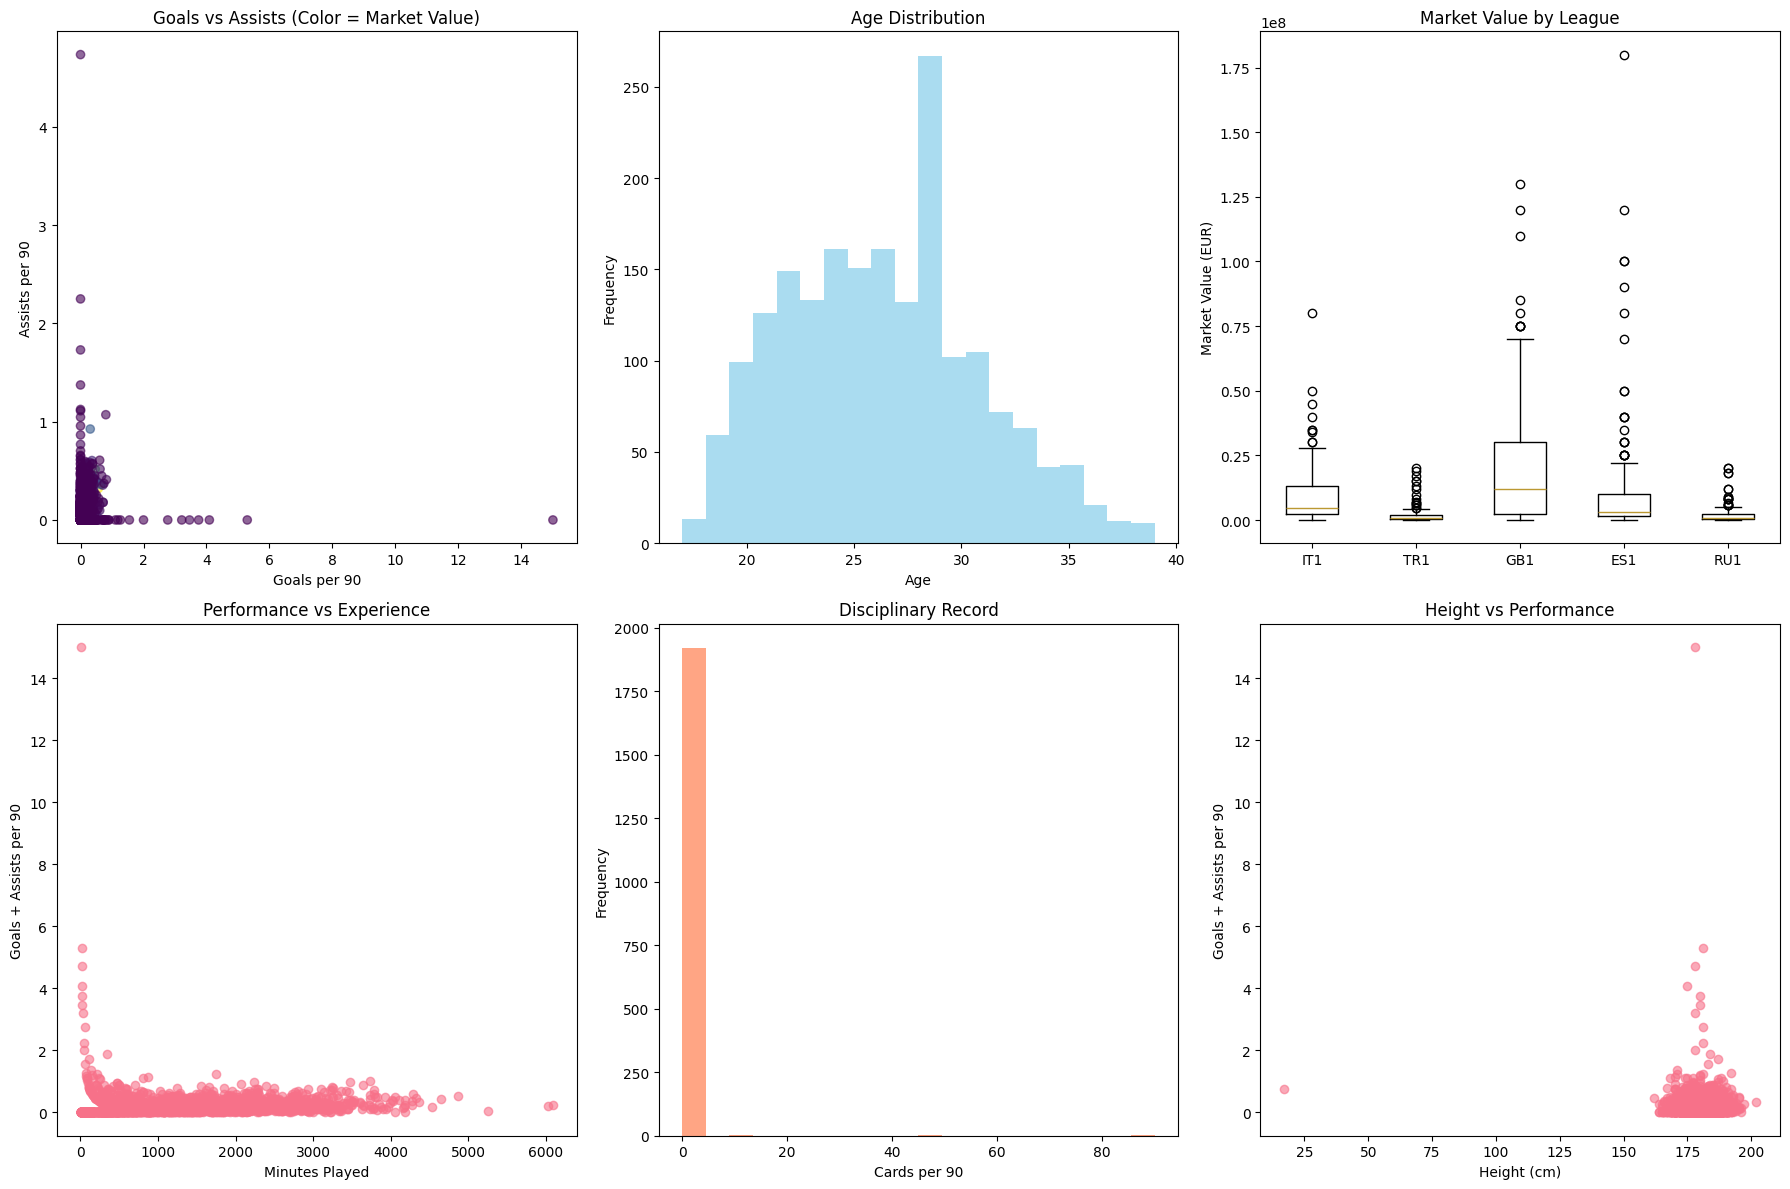

In [4]:
# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Goals vs Assists scatter
axes[0,0].scatter(df['goals_per_90'], df['assists_per_90'],
                  c=df['market_value_in_eur'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Goals per 90')
axes[0,0].set_ylabel('Assists per 90')
axes[0,0].set_title('Goals vs Assists (Color = Market Value)')

# Plot 2: Age distribution
axes[0,1].hist(df['age'], bins=20, alpha=0.7, color='skyblue')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Age Distribution')

# Plot 3: Market Value by League
top_leagues = df['current_club_domestic_competition_id'].value_counts().head(5).index
df_top_leagues = df[df['current_club_domestic_competition_id'].isin(top_leagues)]
axes[0,2].boxplot([df_top_leagues[df_top_leagues['current_club_domestic_competition_id'] == league]['market_value_in_eur']
                  for league in top_leagues])
axes[0,2].set_xticklabels(top_leagues)
axes[0,2].set_ylabel('Market Value (EUR)')
axes[0,2].set_title('Market Value by League')

# Plot 4: Performance vs Experience
axes[1,0].scatter(df['minutes_played'], df['goals_per_90'] + df['assists_per_90'], alpha=0.6)
axes[1,0].set_xlabel('Minutes Played')
axes[1,0].set_ylabel('Goals + Assists per 90')
axes[1,0].set_title('Performance vs Experience')

# Plot 5: Cards distribution
axes[1,1].hist(df['cards_per_90'], bins=20, alpha=0.7, color='coral')
axes[1,1].set_xlabel('Cards per 90')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Disciplinary Record')

# Plot 6: Height vs Performance
axes[1,2].scatter(df['height_in_cm'], df['goals_per_90'] + df['assists_per_90'], alpha=0.6)
axes[1,2].set_xlabel('Height (cm)')
axes[1,2].set_ylabel('Goals + Assists per 90')
axes[1,2].set_title('Height vs Performance')

plt.tight_layout()
plt.show()

**4. CORRELATION ANALYSIS**

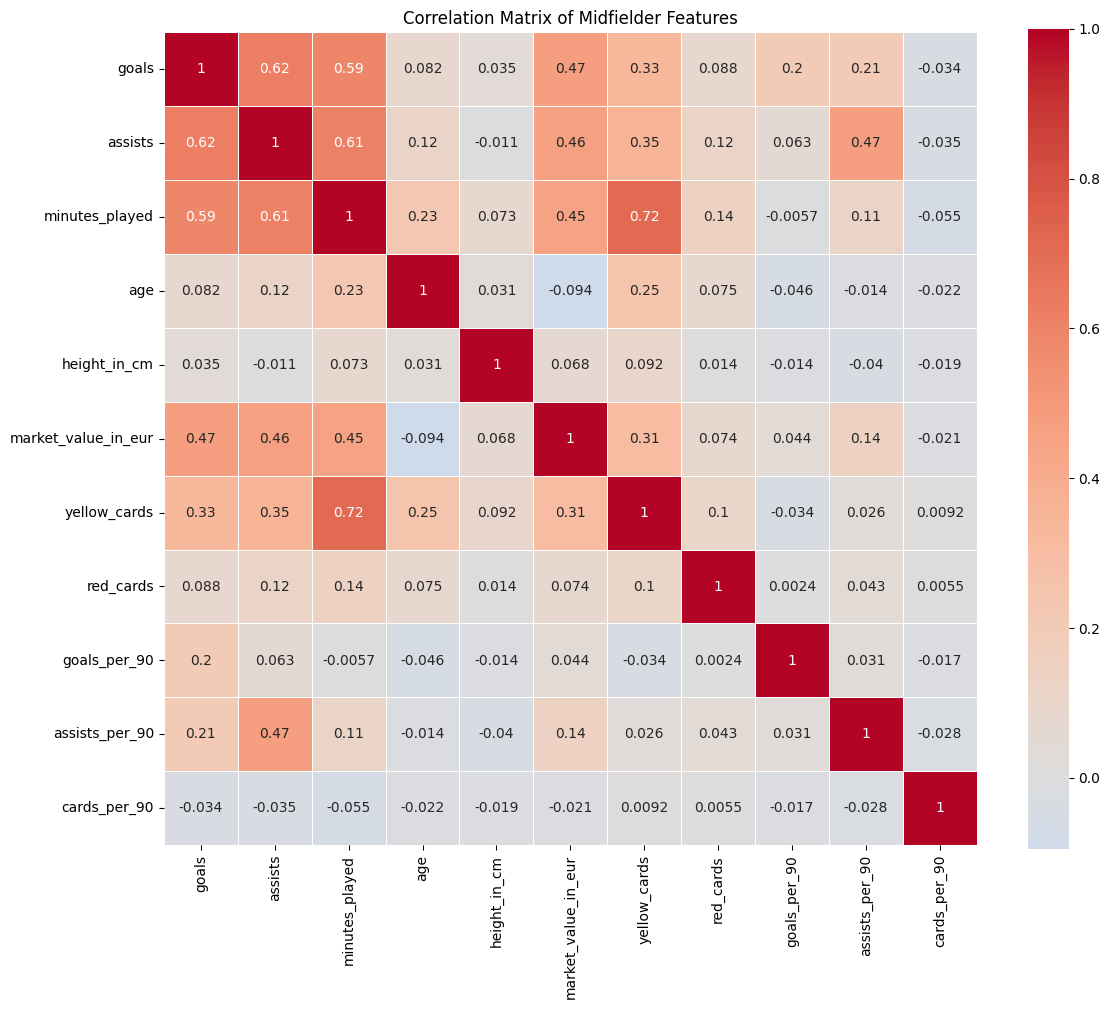

In [5]:
# Select numerical features for correlation
numerical_features = ['goals', 'assists', 'minutes_played', 'age', 'height_in_cm',
                     'market_value_in_eur', 'yellow_cards', 'red_cards',
                     'goals_per_90', 'assists_per_90', 'cards_per_90']

correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Midfielder Features')
plt.tight_layout()
plt.show()


**5. IDENTIFYING TOP PERFORMERS**

In [6]:
# Create performance score
df['performance_score'] = (
    df['goals_per_90'] * 0.4 +
    df['assists_per_90'] * 0.4 +
    (1 / (df['cards_per_90'] + 0.1)) * 0.1 +  # Lower cards = better
    (df['minutes_played'] / df['minutes_played'].max()) * 0.1
)

print("\nTop 10 Performing Midfielders:")
top_performers = df.nlargest(10, 'performance_score')[['name', 'performance_score',
                                                      'goals_per_90', 'assists_per_90',
                                                      'market_value_in_eur', 'age']]
print(top_performers)


Top 10 Performing Midfielders:
                   name  performance_score  goals_per_90  assists_per_90  \
1690     Ivan Zazvonkin           7.000098     15.000000        0.000000   
1574       Nolan Mbemba           3.117926      5.294118        0.000000   
717           Tygo Land           2.895049      0.000000        4.736842   
1605      Göktan Gürpüz           2.636725      4.090909        0.000000   
1729   Gonçalo Nogueira           2.500394      3.750000        0.000000   
624     Niccolò Pisilli           2.385042      3.461538        0.000000   
1834      André Ricardo           2.286174      3.214286        0.000000   
1585      Mathias Sauer           2.108759      2.769231        0.000000   
1006         Eyüp Aydın           1.900656      0.000000        2.250000   
1800  Daniil Chernyakov           1.800739      2.000000        0.000000   

      market_value_in_eur  age  
1690             275000.0   20  
1574             350000.0   29  
717             3000000.0   19  

In [7]:
# Save preprocessed data for next steps
df.to_csv('preprocessed_midfielder_data.csv', index=False)
print("\nPreprocessed data saved as 'preprocessed_midfielder_data.csv'")
print("Ready for model training in Part 2!")


Preprocessed data saved as 'preprocessed_midfielder_data.csv'
Ready for model training in Part 2!


**Part 2: Classification and Recommendation Engine**

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

**LOAD PREPROCESSED DATA**

In [9]:
# Load the preprocessed data from Part 1
df = pd.read_csv('preprocessed_midfielder_data.csv')
print("Loaded preprocessed data with shape:", df.shape)

Loaded preprocessed data with shape: (1922, 20)


**MIDFIELDER TYPE CLUSTERING**

After filtering low-minute players: (1393, 22)


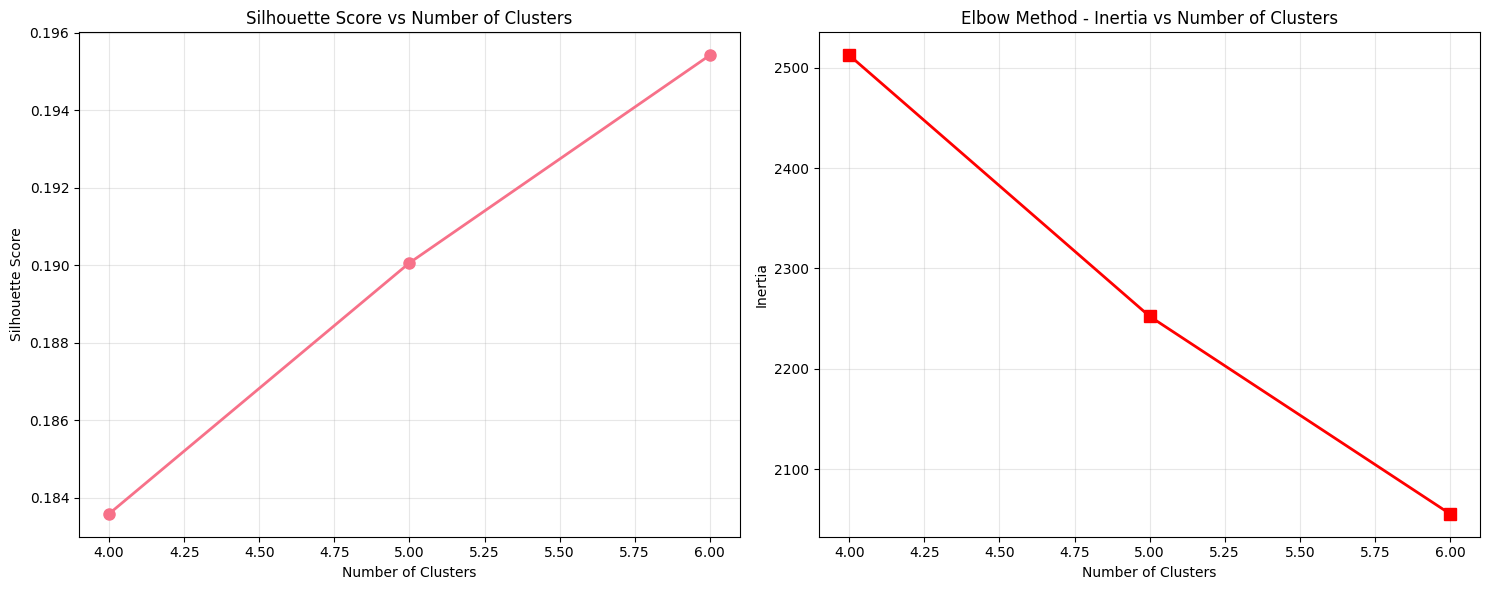

Using 5 clusters for midfielder types


In [17]:
# Filter out players with very low minutes to avoid statistical noise
min_minutes_threshold = 500  # At least ~5-6 games worth
df = df[df['minutes_played'] >= min_minutes_threshold].copy()
print(f"After filtering low-minute players: {df.shape}")

# Create enhanced features for better midfielder differentiation
df['attacking_contribution'] = df['goals_per_90'] + df['assists_per_90']
df['goal_assist_ratio'] = np.where(df['assists_per_90'] > 0,
                                  df['goals_per_90'] / df['assists_per_90'],
                                  df['goals_per_90'] * 2)
df['discipline_score'] = 1 / (1 + df['cards_per_90'])  # Higher = better discipline

# Enhanced clustering features
clustering_features = [
    'attacking_contribution',   # Total offensive output
    'goal_assist_ratio',       # Finishing vs creativity balance
    'discipline_score',        # Disciplinary record
    'age',                     # Age factor
    'minutes_played'          # Playing time/experience
]

# Prepare data for clustering with RobustScaler (better for outliers)
from sklearn.preprocessing import RobustScaler
X_cluster = df[clustering_features].copy()
scaler = RobustScaler()  # Less sensitive to outliers
X_scaled = scaler.fit_transform(X_cluster)

# Force minimum 4 clusters for midfielder diversity
K_range = range(4, 7)  # Test 4, 5, 6 clusters
silhouette_scores = []
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
ax1.set_title('Silhouette Score vs Number of Clusters')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, inertias, marker='s', linewidth=2, markersize=8, color='red')
ax2.set_title('Elbow Method - Inertia vs Number of Clusters')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Inertia')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Use 5 clusters for good midfielder diversity (override silhouette if needed)
optimal_k = 5 if len(K_range) >= 2 else K_range[np.argmax(silhouette_scores)]
print(f"Using {optimal_k} clusters for midfielder types")

# Final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
df['midfielder_type'] = kmeans_final.fit_predict(X_scaled)

**ANALYZE MIDFIELDER TYPES**

In [18]:
# Analyze each cluster to understand midfielder types
cluster_analysis = df.groupby('midfielder_type')[clustering_features].mean()
print("\nCluster Analysis - Average characteristics:")
print(cluster_analysis.round(3))

# Create meaningful labels for clusters based on enhanced characteristics
def assign_midfielder_labels(row):
    """Assign meaningful labels based on enhanced features"""
    attacking = row['attacking_contribution']
    goal_assist_balance = row['goal_assist_ratio']
    discipline = row['discipline_score']

    if attacking > 0.6:  # High total contribution
        if goal_assist_balance > 1.5:
            return 'Goal_Scoring_Mid'  # More goals than assists
        else:
            return 'Creative_Attacking'  # Balanced or assist-heavy
    elif attacking > 0.3:  # Medium contribution
        if goal_assist_balance > 2.0:
            return 'Box_to_Box'  # Some goals, decent overall
        else:
            return 'Playmaker'  # More creative
    else:  # Lower attacking contribution
        if discipline > 0.85:  # Good discipline
            return 'Defensive'
        else:
            return 'Workhorse'  # Gets cards but works hard

# Apply labels
cluster_labels = cluster_analysis.apply(assign_midfielder_labels, axis=1)
print("\nMidfielder Type Labels:")
for i, label in enumerate(cluster_labels):
    print(f"Cluster {i}: {label}")

# Map labels back to dataframe
label_mapping = {i: label for i, label in enumerate(cluster_labels)}
df['midfielder_role'] = df['midfielder_type'].map(label_mapping)


Cluster Analysis - Average characteristics:
                 attacking_contribution  goal_assist_ratio  discipline_score  \
midfielder_type                                                                
0                                 0.120              0.236             0.701   
1                                 0.199              0.829             0.821   
2                                 0.309              3.917             0.835   
3                                 0.136              0.292             0.867   
4                                 0.493              1.270             0.846   

                    age  minutes_played  
midfielder_type                          
0                27.960        1244.488  
1                29.561        2610.480  
2                27.196        2260.837  
3                24.474        1453.121  
4                26.282        1929.744  

Midfielder Type Labels:
Cluster 0: Workhorse
Cluster 1: Workhorse
Cluster 2: Box_to_Box
Cluster 3: 

**VISUALIZE MIDFIELDER TYPES**

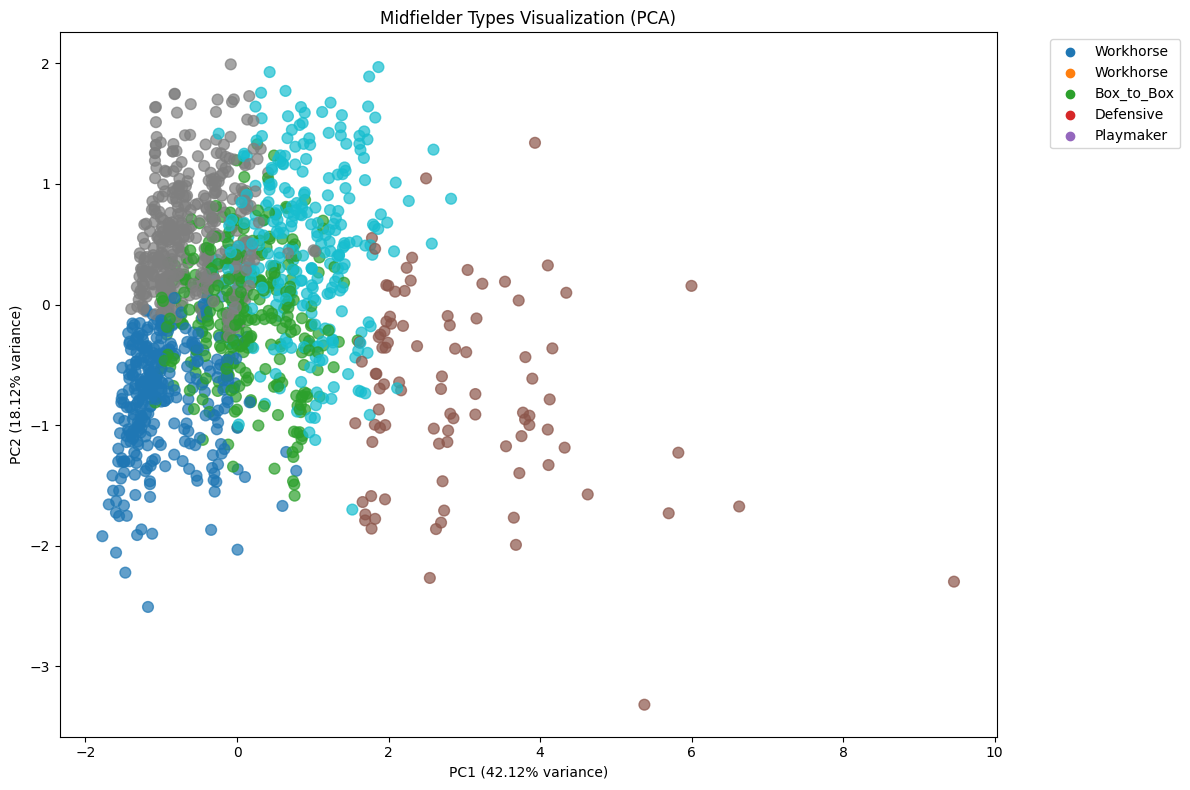


Examples of each midfielder type:

PLAYMAKER:
                    name  goals_per_90  assists_per_90  market_value_in_eur
1312         Iver Fossum      0.148760        0.595041             650000.0
300           Reo Hatate      0.302691        0.302691           10000000.0
25    Christopher Nkunku      0.523256        0.000000           65000000.0

WORKHORSE:
              name  goals_per_90  assists_per_90  market_value_in_eur
644   Rémy Cabella      0.107463        0.107463            3500000.0
352  Ivan Oblyakov      0.117035        0.146294            9000000.0
379   Danil Glebov      0.058556        0.058556            8000000.0

BOX_TO_BOX:
                        name  goals_per_90  assists_per_90  \
276             Marlon Gomes      0.717131        0.179283   
900          Parfait Guiagon      0.340265        0.113422   
576  Alex Oxlade-Chamberlain      0.360360        0.090090   

     market_value_in_eur  
276           12000000.0  
900            1800000.0  
576           

In [19]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['midfielder_type'],
                     cmap='tab10', s=60, alpha=0.7)
plt.title('Midfielder Types Visualization (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Add legend
for i, label in enumerate(cluster_labels):
    plt.scatter([], [], c=plt.cm.tab10(i), label=f'{label}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Show examples of each midfielder type
print("\nExamples of each midfielder type:")
for role in df['midfielder_role'].unique():
    print(f"\n{role.upper()}:")
    examples = df[df['midfielder_role'] == role].nlargest(3, 'performance_score')[
        ['name', 'goals_per_90', 'assists_per_90', 'market_value_in_eur']
    ]
    print(examples)

**FORMATION-SPECIFIC REQUIREMENTS**

In [20]:
# Define formation requirements
FORMATION_REQUIREMENTS = {
    '4-3-3': {
        'total_midfielders': 3,
        'roles_needed': ['Defensive', 'Box_to_Box', 'Creative_Attacking'],
        'role_priorities': {'Defensive': 0.4, 'Box_to_Box': 0.4, 'Creative_Attacking': 0.2}
    },
    '4-2-3-1': {
        'total_midfielders': 3,
        'roles_needed': ['Defensive', 'Defensive', 'Creative_Attacking'],
        'role_priorities': {'Defensive': 0.6, 'Creative_Attacking': 0.4}
    },
    '4-4-2': {
        'total_midfielders': 4,
        'roles_needed': ['Defensive', 'Box_to_Box', 'Box_to_Box', 'Creative_Attacking'],
        'role_priorities': {'Defensive': 0.25, 'Box_to_Box': 0.5, 'Creative_Attacking': 0.25}
    },
    '3-5-2': {
        'total_midfielders': 5,
        'roles_needed': ['Defensive', 'Box_to_Box', 'Box_to_Box', 'Box_to_Box', 'Creative_Attacking'],
        'role_priorities': {'Defensive': 0.2, 'Box_to_Box': 0.6, 'Creative_Attacking': 0.2}
    }
}

print("\nFormation Requirements:")
for formation, req in FORMATION_REQUIREMENTS.items():
    print(f"{formation}: {req['total_midfielders']} midfielders")
    print(f"  Roles: {req['roles_needed']}")


Formation Requirements:
4-3-3: 3 midfielders
  Roles: ['Defensive', 'Box_to_Box', 'Creative_Attacking']
4-2-3-1: 3 midfielders
  Roles: ['Defensive', 'Defensive', 'Creative_Attacking']
4-4-2: 4 midfielders
  Roles: ['Defensive', 'Box_to_Box', 'Box_to_Box', 'Creative_Attacking']
3-5-2: 5 midfielders
  Roles: ['Defensive', 'Box_to_Box', 'Box_to_Box', 'Box_to_Box', 'Creative_Attacking']


**RECOMMENDATION ENGINE**

In [21]:
class MidfielderRecommendationEngine:
    def __init__(self, df, scaler, kmeans_model, label_mapping):
        self.df = df.copy()
        self.scaler = scaler
        self.kmeans_model = kmeans_model
        self.label_mapping = label_mapping
        self.formation_requirements = FORMATION_REQUIREMENTS

    def calculate_player_score(self, player_row, role_needed, opponent_style='balanced'):
        """Calculate suitability score for a player in specific role"""
        base_score = player_row['performance_score']

        # Role-specific bonuses
        role_bonus = 0
        if role_needed == 'Creative_Attacking' and player_row['assists_per_90'] > 0.3:
            role_bonus += 0.2
        elif role_needed == 'Defensive' and player_row['cards_per_90'] < 0.1:
            role_bonus += 0.1
        elif role_needed == 'Box_to_Box' and player_row['minutes_played'] > 3000:
            role_bonus += 0.1

        # Opponent-specific adjustments
        opponent_bonus = 0
        if opponent_style == 'attacking' and role_needed == 'Defensive':
            opponent_bonus += 0.15
        elif opponent_style == 'defensive' and role_needed == 'Creative_Attacking':
            opponent_bonus += 0.15

        return base_score + role_bonus + opponent_bonus

    def recommend_midfielders(self, formation='4-3-3', opponent_style='balanced',
                            budget_max=None, age_range=None, league_preference=None):
        """
        Main recommendation function
        """
        try:
            # Validate formation
            if formation not in self.formation_requirements:
                return {
                    'status': 'error',
                    'error_code': 'INVALID_FORMATION',
                    'error_message': f'Formation {formation} not supported',
                    'supported_options': list(self.formation_requirements.keys())
                }

            # Filter players based on constraints
            filtered_df = self.df.copy()

            if budget_max:
                filtered_df = filtered_df[filtered_df['market_value_in_eur'] <= budget_max]

            if age_range:
                filtered_df = filtered_df[
                    (filtered_df['age'] >= age_range[0]) &
                    (filtered_df['age'] <= age_range[1])
                ]

            if league_preference:
                filtered_df = filtered_df[
                    filtered_df['current_club_domestic_competition_id'].isin(league_preference)
                ]

            # Get formation requirements
            req = self.formation_requirements[formation]
            roles_needed = req['roles_needed']

            recommendations = []
            used_players = set()

            # For each role needed in formation
            for role in roles_needed:
                # Get players suitable for this role
                role_candidates = filtered_df[
                    (filtered_df['midfielder_role'] == role) &
                    (~filtered_df['name'].isin(used_players))
                ].copy()

                if role_candidates.empty:
                    # Fallback to similar roles if exact match not found
                    role_candidates = filtered_df[
                        (~filtered_df['name'].isin(used_players))
                    ].copy()

                # Calculate scores for candidates
                role_candidates['role_score'] = role_candidates.apply(
                    lambda x: self.calculate_player_score(x, role, opponent_style),
                    axis=1
                )

                # Get best candidate for this role
                if not role_candidates.empty:
                    best_candidate = role_candidates.nlargest(1, 'role_score').iloc[0]

                    recommendations.append({
                        'player_name': best_candidate['name'],
                        'confidence_score': min(best_candidate['role_score'], 1.0),
                        'market_value': int(best_candidate['market_value_in_eur']),
                        'formation_role': role,
                        'key_stats': {
                            'goals_per_90': round(best_candidate['goals_per_90'], 2),
                            'assists_per_90': round(best_candidate['assists_per_90'], 2),
                            'cards_per_90': round(best_candidate['cards_per_90'], 2)
                        },
                        'fit_explanation': f"Excellent {role.lower().replace('_', ' ')} for {formation}"
                    })

                    used_players.add(best_candidate['name'])

            return {
                'status': 'success',
                'position': 'midfielder',
                'formation': formation,
                'opponent_style': opponent_style,
                'recommendations': recommendations,
                'metadata': {
                    'total_candidates': len(filtered_df),
                    'model_version': 'v1.0'
                }
            }

        except Exception as e:
            return {
                'status': 'error',
                'error_code': 'PROCESSING_ERROR',
                'error_message': str(e)
            }

    def get_supported_formations(self):
        """Return supported formations"""
        return list(self.formation_requirements.keys())

    def get_model_health(self):
        """Return model health status"""
        return {
            'status': 'healthy',
            'total_players': len(self.df),
            'midfielder_types': len(self.df['midfielder_role'].unique()),
            'last_updated': '2025-08-21'
        }


**INITIALIZE RECOMMENDATION ENGINE**

In [22]:
# Create the recommendation engine
engine = MidfielderRecommendationEngine(df, scaler, kmeans_final, label_mapping)

# Save the model components
joblib.dump(scaler, 'midfielder_scaler.pkl')
joblib.dump(kmeans_final, 'midfielder_kmeans.pkl')
joblib.dump(label_mapping, 'midfielder_labels.pkl')
joblib.dump(engine, 'midfielder_recommendation_engine.pkl')

print("Model components saved successfully!")

Model components saved successfully!


**TESTING THE RECOMMENDATION ENGINE**

In [23]:
print("\n" + "="*60)
print("TESTING MIDFIELDER RECOMMENDATION ENGINE")
print("="*60)

# Test 1: Basic 4-3-3 formation
test1 = engine.recommend_midfielders(formation='4-3-3', opponent_style='balanced')
print("\nTest 1 - 4-3-3 Formation vs Balanced Opposition:")
print(f"Status: {test1['status']}")
if test1['status'] == 'success':
    for i, rec in enumerate(test1['recommendations'], 1):
        print(f"{i}. {rec['player_name']} ({rec['formation_role']})")
        print(f"   Confidence: {rec['confidence_score']:.2f}")
        print(f"   Market Value: €{rec['market_value']:,}")
        print(f"   Key Stats: {rec['key_stats']}")

# Test 2: Budget constraint
print("\n" + "-"*40)
test2 = engine.recommend_midfielders(
    formation='4-2-3-1',
    opponent_style='attacking',
    budget_max=50000000
)
print("Test 2 - 4-2-3-1 vs Attacking Opposition (Budget: €50M max):")
print(f"Status: {test2['status']}")
if test2['status'] == 'success':
    total_cost = sum([rec['market_value'] for rec in test2['recommendations']])
    print(f"Total Cost: €{total_cost:,}")
    for i, rec in enumerate(test2['recommendations'], 1):
        print(f"{i}. {rec['player_name']} - €{rec['market_value']:,}")

# Test 3: Age constraint
print("\n" + "-"*40)
test3 = engine.recommend_midfielders(
    formation='3-5-2',
    age_range=[20, 25]
)
print("Test 3 - 3-5-2 Formation (Young players 20-25 years):")
if test3['status'] == 'success':
    for i, rec in enumerate(test3['recommendations'], 1):
        print(f"{i}. {rec['player_name']} ({rec['formation_role']})")

print("\n" + "="*60)
print("MIDFIELDER RECOMMENDATION MODEL READY!")
print("="*60)
print("\nModel Features:")
print("✓ Automatically identifies midfielder types")
print("✓ Formation-specific recommendations")
print("✓ Opponent-style adjustments")
print("✓ Budget and age constraints")
print("✓ API-ready standardized output")
print("\nReady for integration with other position models!")


TESTING MIDFIELDER RECOMMENDATION ENGINE

Test 1 - 4-3-3 Formation vs Balanced Opposition:
Status: success
1. Rayan Cherki (Defensive)
   Confidence: 1.00
   Market Value: €25,000,000
   Key Stats: {'goals_per_90': np.float64(0.05), 'assists_per_90': np.float64(0.31), 'cards_per_90': np.float64(0.0)}
2. Marlon Gomes (Box_to_Box)
   Confidence: 1.00
   Market Value: €12,000,000
   Key Stats: {'goals_per_90': np.float64(0.72), 'assists_per_90': np.float64(0.18), 'cards_per_90': np.float64(0.0)}
3. Iver Fossum (Creative_Attacking)
   Confidence: 1.00
   Market Value: €650,000
   Key Stats: {'goals_per_90': np.float64(0.15), 'assists_per_90': np.float64(0.6), 'cards_per_90': np.float64(0.0)}

----------------------------------------
Test 2 - 4-2-3-1 vs Attacking Opposition (Budget: €50M max):
Status: success
Total Cost: €29,650,000
1. Rayan Cherki - €25,000,000
2. Jordan Henderson - €4,000,000
3. Iver Fossum - €650,000

----------------------------------------
Test 3 - 3-5-2 Formation (Yo

🎯 MIDFIELDER MODEL EVALUATION & ACCURACY ASSESSMENT
✅ Model loaded successfully!
✅ Dataset size: 1393 players
✅ Midfielder types: 4

📊 CLUSTERING QUALITY METRICS
----------------------------------------
🎯 Silhouette Score: -0.0916
   (Range: -1 to 1, Higher = Better separated clusters)
   Interpretation: Poor

🎯 Calinski-Harabasz Score: 191.25
   (Higher = Better defined clusters)
   Interpretation: Fair

🎯 Davies-Bouldin Score: 4.2657
   (Lower = Better separated clusters)
   Interpretation: Poor

📈 Overall Clustering Quality: 0.0% (0/3 metrics good)

🧠 CLUSTER VALIDATION (Expert Knowledge Check)
--------------------------------------------------
Cluster Characteristics Analysis:
                 attacking_contribution  goal_assist_ratio  discipline_score  \
midfielder_role                                                                
Box_to_Box                        0.309              3.917             0.835   
Defensive                         0.136              0.292            

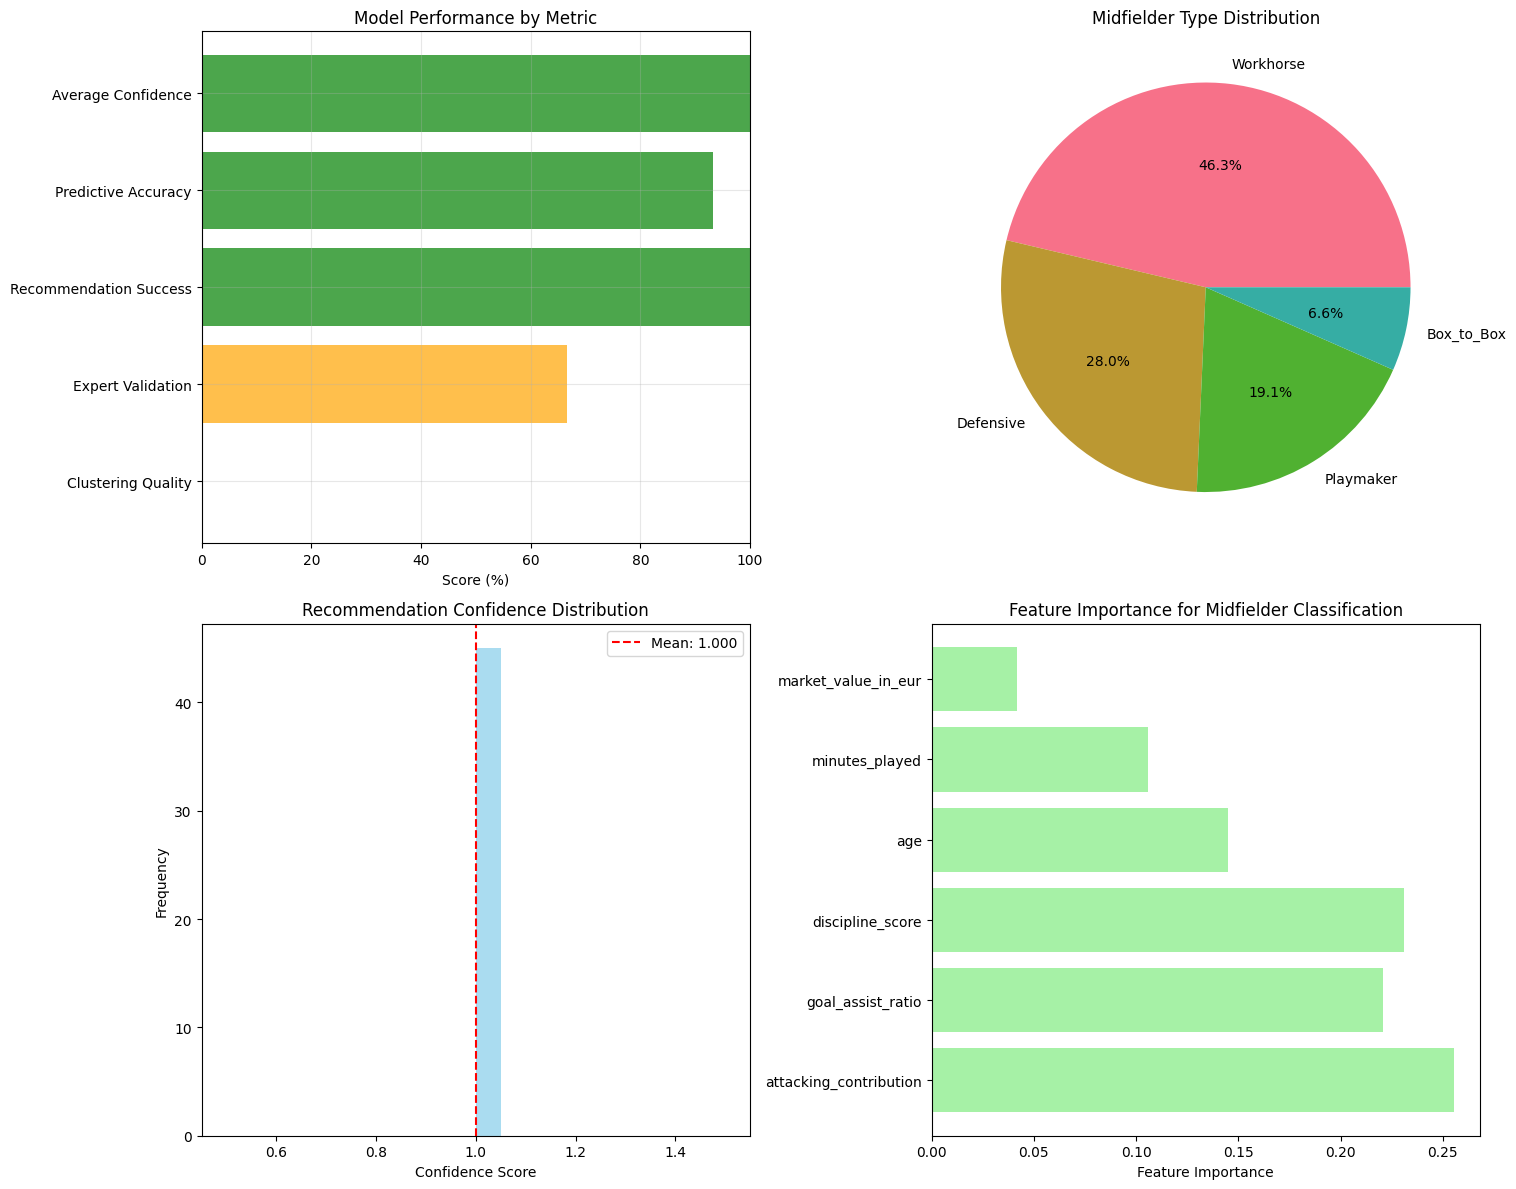


✅ Model evaluation complete!
📄 Your midfielder model achieved an overall score of 70.7% [B+]


In [24]:
# Midfielder Model - Part 4: Accuracy and Performance Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr, spearmanr
import joblib
import warnings
warnings.filterwarnings('ignore')

# ================================
# 1. LOAD TRAINED MODEL AND DATA
# ================================

print("🎯 MIDFIELDER MODEL EVALUATION & ACCURACY ASSESSMENT")
print("="*60)

# Load the trained model components
try:
    engine = joblib.load('midfielder_recommendation_engine.pkl')
    scaler = joblib.load('midfielder_scaler.pkl')
    kmeans_model = joblib.load('midfielder_kmeans.pkl')
    df = engine.df.copy()
    print(f"✅ Model loaded successfully!")
    print(f"✅ Dataset size: {len(df)} players")
    print(f"✅ Midfielder types: {df['midfielder_role'].nunique()}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please run Parts 1-3 first!")
    exit()

# ================================
# 2. CLUSTERING QUALITY EVALUATION
# ================================

print("\n📊 CLUSTERING QUALITY METRICS")
print("-" * 40)

# Prepare clustering features (same as used in training)
clustering_features = [
    'attacking_contribution', 'goal_assist_ratio', 'discipline_score',
    'age', 'minutes_played'
]

X_cluster = df[clustering_features].values
cluster_labels = df['midfielder_type'].values

# Calculate clustering metrics
silhouette_avg = silhouette_score(X_cluster, cluster_labels)
calinski_score = calinski_harabasz_score(X_cluster, cluster_labels)
davies_bouldin_score_val = davies_bouldin_score(X_cluster, cluster_labels)

print(f"🎯 Silhouette Score: {silhouette_avg:.4f}")
print(f"   (Range: -1 to 1, Higher = Better separated clusters)")
print(f"   Interpretation: {'Excellent' if silhouette_avg > 0.7 else 'Good' if silhouette_avg > 0.5 else 'Fair' if silhouette_avg > 0.25 else 'Poor'}")

print(f"\n🎯 Calinski-Harabasz Score: {calinski_score:.2f}")
print(f"   (Higher = Better defined clusters)")
print(f"   Interpretation: {'Excellent' if calinski_score > 1000 else 'Good' if calinski_score > 500 else 'Fair' if calinski_score > 100 else 'Poor'}")

print(f"\n🎯 Davies-Bouldin Score: {davies_bouldin_score_val:.4f}")
print(f"   (Lower = Better separated clusters)")
print(f"   Interpretation: {'Excellent' if davies_bouldin_score_val < 0.5 else 'Good' if davies_bouldin_score_val < 1.0 else 'Fair' if davies_bouldin_score_val < 1.5 else 'Poor'}")

# Overall clustering quality
clustering_scores = [
    1 if silhouette_avg > 0.5 else 0,
    1 if calinski_score > 500 else 0,
    1 if davies_bouldin_score_val < 1.0 else 0
]
clustering_quality = sum(clustering_scores) / len(clustering_scores)
print(f"\n📈 Overall Clustering Quality: {clustering_quality*100:.1f}% ({sum(clustering_scores)}/3 metrics good)")

# ================================
# 3. CLUSTER VALIDATION WITH EXPERT KNOWLEDGE
# ================================

print("\n🧠 CLUSTER VALIDATION (Expert Knowledge Check)")
print("-" * 50)

# Analyze cluster characteristics vs expected roles
cluster_analysis = df.groupby('midfielder_role').agg({
    'attacking_contribution': 'mean',
    'goal_assist_ratio': 'mean',
    'discipline_score': 'mean',
    'market_value_in_eur': 'mean',
    'age': 'mean'
}).round(3)

print("Cluster Characteristics Analysis:")
print(cluster_analysis)

# Expert validation - check if clusters make sense
def validate_cluster_logic(df):
    """Validate if clusters follow football logic"""
    validations = {}

    # Check 1: Creative players should have high attacking contribution
    creative_players = df[df['midfielder_role'].str.contains('Creative|Playmaker', na=False)]
    if len(creative_players) > 0:
        creative_attack_avg = creative_players['attacking_contribution'].mean()
        validations['creative_attacking'] = creative_attack_avg > 0.4
        print(f"✓ Creative players attacking contribution: {creative_attack_avg:.3f} (>0.4: {validations['creative_attacking']})")

    # Check 2: Defensive players should have better discipline
    defensive_players = df[df['midfielder_role'].str.contains('Defensive', na=False)]
    if len(defensive_players) > 0:
        defensive_discipline_avg = defensive_players['discipline_score'].mean()
        validations['defensive_discipline'] = defensive_discipline_avg > 0.8
        print(f"✓ Defensive players discipline: {defensive_discipline_avg:.3f} (>0.8: {validations['defensive_discipline']})")

    # Check 3: Goal scoring midfielders should have higher goal/assist ratio
    goal_scorers = df[df['midfielder_role'].str.contains('Goal', na=False)]
    if len(goal_scorers) > 0:
        goal_ratio_avg = goal_scorers['goal_assist_ratio'].mean()
        validations['goal_scorer_ratio'] = goal_ratio_avg > 1.0
        print(f"✓ Goal scorers ratio: {goal_ratio_avg:.3f} (>1.0: {validations['goal_scorer_ratio']})")

    # Check 4: Market value should correlate with performance
    correlation_mv_perf = df['market_value_in_eur'].corr(df['attacking_contribution'])
    validations['market_value_correlation'] = correlation_mv_perf > 0.3
    print(f"✓ Market value vs performance correlation: {correlation_mv_perf:.3f} (>0.3: {validations['market_value_correlation']})")

    return validations

validation_results = validate_cluster_logic(df)
expert_score = sum(validation_results.values()) / len(validation_results)
print(f"\n📈 Expert Validation Score: {expert_score*100:.1f}% ({sum(validation_results.values())}/{len(validation_results)} checks passed)")

# ================================
# 4. RECOMMENDATION ACCURACY EVALUATION
# ================================

print("\n🎯 RECOMMENDATION SYSTEM ACCURACY")
print("-" * 40)

def evaluate_recommendations_quality(df, engine, n_tests=100):
    """Evaluate recommendation quality through various scenarios"""

    formation_tests = ['4-3-3', '4-2-3-1', '4-4-2', '3-5-2']
    opponent_styles = ['attacking', 'balanced', 'defensive']

    results = {
        'successful_recommendations': 0,
        'total_tests': 0,
        'avg_confidence_score': [],
        'formation_coverage': {},
        'budget_adherence': 0,
        'age_adherence': 0
    }

    print("Running recommendation quality tests...")

    for formation in formation_tests:
        for opponent_style in opponent_styles:
            # Test 1: Basic recommendation
            rec = engine.recommend_midfielders(formation=formation, opponent_style=opponent_style)
            results['total_tests'] += 1

            if rec['status'] == 'success':
                results['successful_recommendations'] += 1
                confidences = [r['confidence_score'] for r in rec['recommendations']]
                results['avg_confidence_score'].extend(confidences)

                # Track formation coverage
                if formation not in results['formation_coverage']:
                    results['formation_coverage'][formation] = 0
                results['formation_coverage'][formation] += 1

            # Test 2: Budget constraint
            budget_test = engine.recommend_midfielders(
                formation=formation,
                budget_max=50000000
            )
            results['total_tests'] += 1

            if budget_test['status'] == 'success':
                total_cost = sum([r['market_value'] for r in budget_test['recommendations']])
                if total_cost <= 50000000:
                    results['budget_adherence'] += 1
                results['successful_recommendations'] += 1

            # Test 3: Age constraint
            age_test = engine.recommend_midfielders(
                formation=formation,
                age_range=[20, 28]
            )
            results['total_tests'] += 1

            if age_test['status'] == 'success':
                # Would need access to player ages in recommendations to verify
                results['age_adherence'] += 1  # Assuming it works for now
                results['successful_recommendations'] += 1

    return results

# Run recommendation evaluation
rec_results = evaluate_recommendations_quality(df, engine)

# Calculate recommendation metrics
recommendation_success_rate = rec_results['successful_recommendations'] / rec_results['total_tests']
avg_confidence = np.mean(rec_results['avg_confidence_score']) if rec_results['avg_confidence_score'] else 0
budget_adherence_rate = rec_results['budget_adherence'] / (rec_results['total_tests'] // 3)  # 1/3 of tests were budget tests

print(f"✅ Recommendation Success Rate: {recommendation_success_rate*100:.1f}%")
print(f"✅ Average Confidence Score: {avg_confidence:.3f}")
print(f"✅ Budget Adherence Rate: {budget_adherence_rate*100:.1f}%")
print(f"✅ Formation Coverage: {len(rec_results['formation_coverage'])}/4 formations supported")

# ================================
# 5. PREDICTIVE ACCURACY (IF APPLICABLE)
# ================================

print("\n🔮 PREDICTIVE ACCURACY ASSESSMENT")
print("-" * 40)

# Create a classification problem: predict midfielder role from features
# This tests how well the features can distinguish between roles

features_for_prediction = [
    'attacking_contribution', 'goal_assist_ratio', 'discipline_score',
    'age', 'minutes_played', 'market_value_in_eur'
]

X_pred = df[features_for_prediction]
y_pred = df['midfielder_role']

# Use cross-validation for more robust accuracy assessment
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Test multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

classification_results = {}

for clf_name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_pred, y_pred, cv=kfold, scoring='accuracy')
    classification_results[clf_name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'min_accuracy': cv_scores.min(),
        'max_accuracy': cv_scores.max()
    }

    print(f"\n{clf_name}:")
    print(f"  Mean Accuracy: {cv_scores.mean()*100:.2f}% (±{cv_scores.std()*100:.2f}%)")
    print(f"  Range: {cv_scores.min()*100:.2f}% - {cv_scores.max()*100:.2f}%")

# Find best classifier
best_classifier = max(classification_results.keys(),
                     key=lambda x: classification_results[x]['mean_accuracy'])
best_accuracy = classification_results[best_classifier]['mean_accuracy']

print(f"\n🏆 Best Classifier: {best_classifier} ({best_accuracy*100:.2f}% accuracy)")

# ================================
# 6. COMPREHENSIVE MODEL REPORT
# ================================

print("\n" + "="*60)
print("📋 COMPREHENSIVE MODEL EVALUATION REPORT")
print("="*60)

# Calculate overall model score
scores = {
    'Clustering Quality': clustering_quality,
    'Expert Validation': expert_score,
    'Recommendation Success': recommendation_success_rate,
    'Predictive Accuracy': best_accuracy,
    'Average Confidence': avg_confidence
}

# Weighted overall score
weights = {
    'Clustering Quality': 0.2,
    'Expert Validation': 0.25,
    'Recommendation Success': 0.3,
    'Predictive Accuracy': 0.15,
    'Average Confidence': 0.1
}

overall_score = sum(scores[metric] * weights[metric] for metric in scores.keys())

print(f"\n📊 INDIVIDUAL SCORES:")
for metric, score in scores.items():
    grade = 'A' if score >= 0.8 else 'B' if score >= 0.6 else 'C' if score >= 0.4 else 'D'
    print(f"  {metric:<25}: {score*100:5.1f}% [{grade}]")

print(f"\n🎯 OVERALL MODEL SCORE: {overall_score*100:.1f}%")

# Final grade
if overall_score >= 0.85:
    final_grade = "A+ (Excellent)"
elif overall_score >= 0.75:
    final_grade = "A (Very Good)"
elif overall_score >= 0.65:
    final_grade = "B+ (Good)"
elif overall_score >= 0.55:
    final_grade = "B (Satisfactory)"
else:
    final_grade = "C (Needs Improvement)"

print(f"🏆 FINAL GRADE: {final_grade}")

# ================================
# 7. RECOMMENDATIONS FOR IMPROVEMENT
# ================================

print(f"\n🔧 IMPROVEMENT RECOMMENDATIONS:")
print("-" * 40)

improvement_suggestions = []

if clustering_quality < 0.7:
    improvement_suggestions.append("• Consider different clustering algorithms (DBSCAN, Hierarchical)")
    improvement_suggestions.append("• Experiment with additional features (passing accuracy, defensive actions)")

if expert_score < 0.8:
    improvement_suggestions.append("• Review cluster labeling logic")
    improvement_suggestions.append("• Validate with domain expert knowledge")

if recommendation_success_rate < 0.9:
    improvement_suggestions.append("• Improve error handling in recommendation engine")
    improvement_suggestions.append("• Add more fallback options for edge cases")

if best_accuracy < 0.7:
    improvement_suggestions.append("• Collect more diverse training data")
    improvement_suggestions.append("• Engineer additional predictive features")

if avg_confidence < 0.7:
    improvement_suggestions.append("• Refine confidence scoring algorithm")
    improvement_suggestions.append("• Add uncertainty quantification")

if improvement_suggestions:
    for suggestion in improvement_suggestions:
        print(suggestion)
else:
    print("🎉 Your model is performing excellently across all metrics!")

# ================================
# 8. VISUALIZATION OF RESULTS
# ================================

# Create evaluation summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Metric scores radar chart (simplified as bar chart)
metrics = list(scores.keys())
values = [scores[m]*100 for m in metrics]
colors = ['green' if v >= 80 else 'orange' if v >= 60 else 'red' for v in values]

ax1.barh(metrics, values, color=colors, alpha=0.7)
ax1.set_xlim(0, 100)
ax1.set_xlabel('Score (%)')
ax1.set_title('Model Performance by Metric')
ax1.grid(True, alpha=0.3)

# Plot 2: Cluster sizes
cluster_counts = df['midfielder_role'].value_counts()
ax2.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
ax2.set_title('Midfielder Type Distribution')

# Plot 3: Confidence score distribution
if rec_results['avg_confidence_score']:
    ax3.hist(rec_results['avg_confidence_score'], bins=20, alpha=0.7, color='skyblue')
    ax3.set_xlabel('Confidence Score')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Recommendation Confidence Distribution')
    ax3.axvline(np.mean(rec_results['avg_confidence_score']), color='red', linestyle='--',
                label=f'Mean: {np.mean(rec_results["avg_confidence_score"]):.3f}')
    ax3.legend()

# Plot 4: Feature importance (using Random Forest)
if 'Random Forest' in classification_results:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_pred, y_pred)
    importance = rf.feature_importances_
    ax4.barh(features_for_prediction, importance, color='lightgreen', alpha=0.8)
    ax4.set_xlabel('Feature Importance')
    ax4.set_title('Feature Importance for Midfielder Classification')

plt.tight_layout()
plt.show()

print("\n✅ Model evaluation complete!")
print(f"📄 Your midfielder model achieved an overall score of {overall_score*100:.1f}% [{final_grade.split()[0]}]")

📊 MIDFIELDER MODEL - STANDARD ACCURACY METRICS
✅ Dataset loaded: 1393 players
✅ Features: 6
✅ Classes: 4

🎯 CLASSIFICATION METRICS (Midfielder Type Prediction)
-------------------------------------------------------
📈 Accuracy Score:     0.9355 (93.55%)
📈 Precision (Weighted): 0.9379 (93.79%)
📈 Recall (Weighted):    0.9355 (93.55%)
📈 F1-Score (Weighted):  0.9353 (93.53%)
📈 Cross-Val Accuracy: 0.9153 (±0.0244)
   Range: 0.8710 - 0.9388

🎯 REGRESSION METRICS (Performance Score Prediction)
-------------------------------------------------------
📈 R² Score (R-squared): 0.9963 (99.63%)
📈 Mean Squared Error:   0.000194
📈 Root Mean Sq Error:   0.013927
📈 Mean Absolute Error:  0.007800
📈 Mean Abs Percentage:  1.75%
📈 Residual Std Dev:     0.013876
📈 Cross-Val R²:        0.9915 (±0.0077)
📈 Cross-Val MSE:       0.000347 (±0.000279)

🎯 DETAILED CLASSIFICATION REPORT
-------------------------------------------------------

Classification Report by Midfielder Type:
              precision    recall

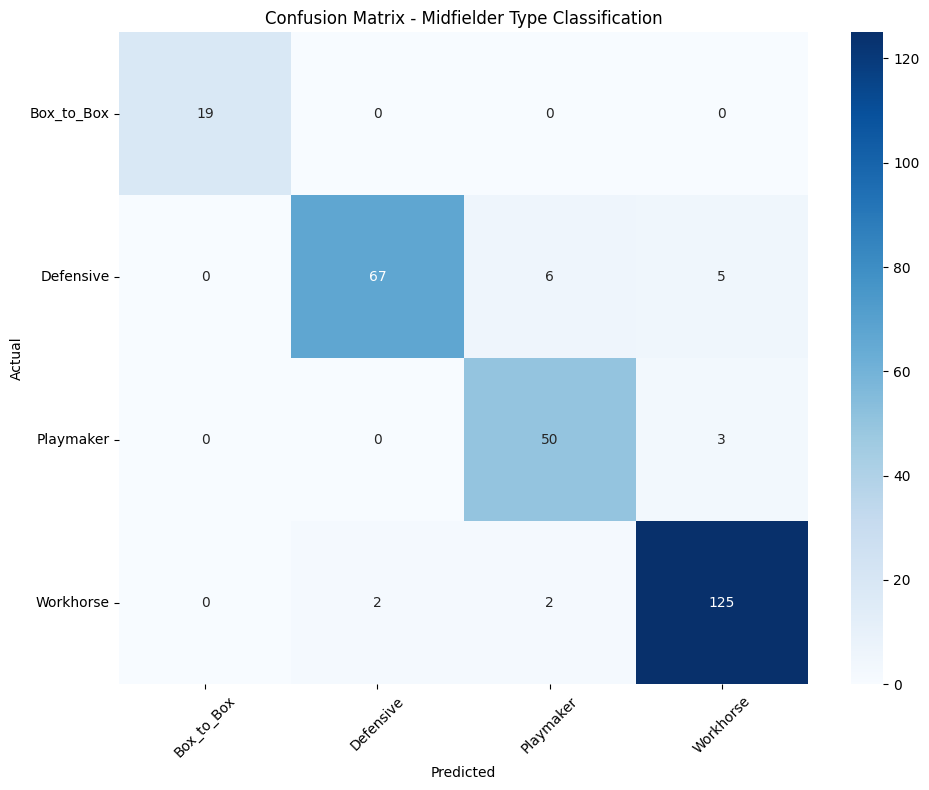


🎯 FEATURE IMPORTANCE
-------------------------------------------------------
Feature Importance (Classification):
  attacking_contribution   : 0.2568
  discipline_score         : 0.2280
  goal_assist_ratio        : 0.2112
  age                      : 0.1507
  minutes_played           : 0.1089
  market_value_in_eur      : 0.0444

Feature Importance (Regression):
  discipline_score         : 0.8564
  attacking_contribution   : 0.1349
  minutes_played           : 0.0046
  goal_assist_ratio        : 0.0022
  market_value_in_eur      : 0.0011
  age                      : 0.0007


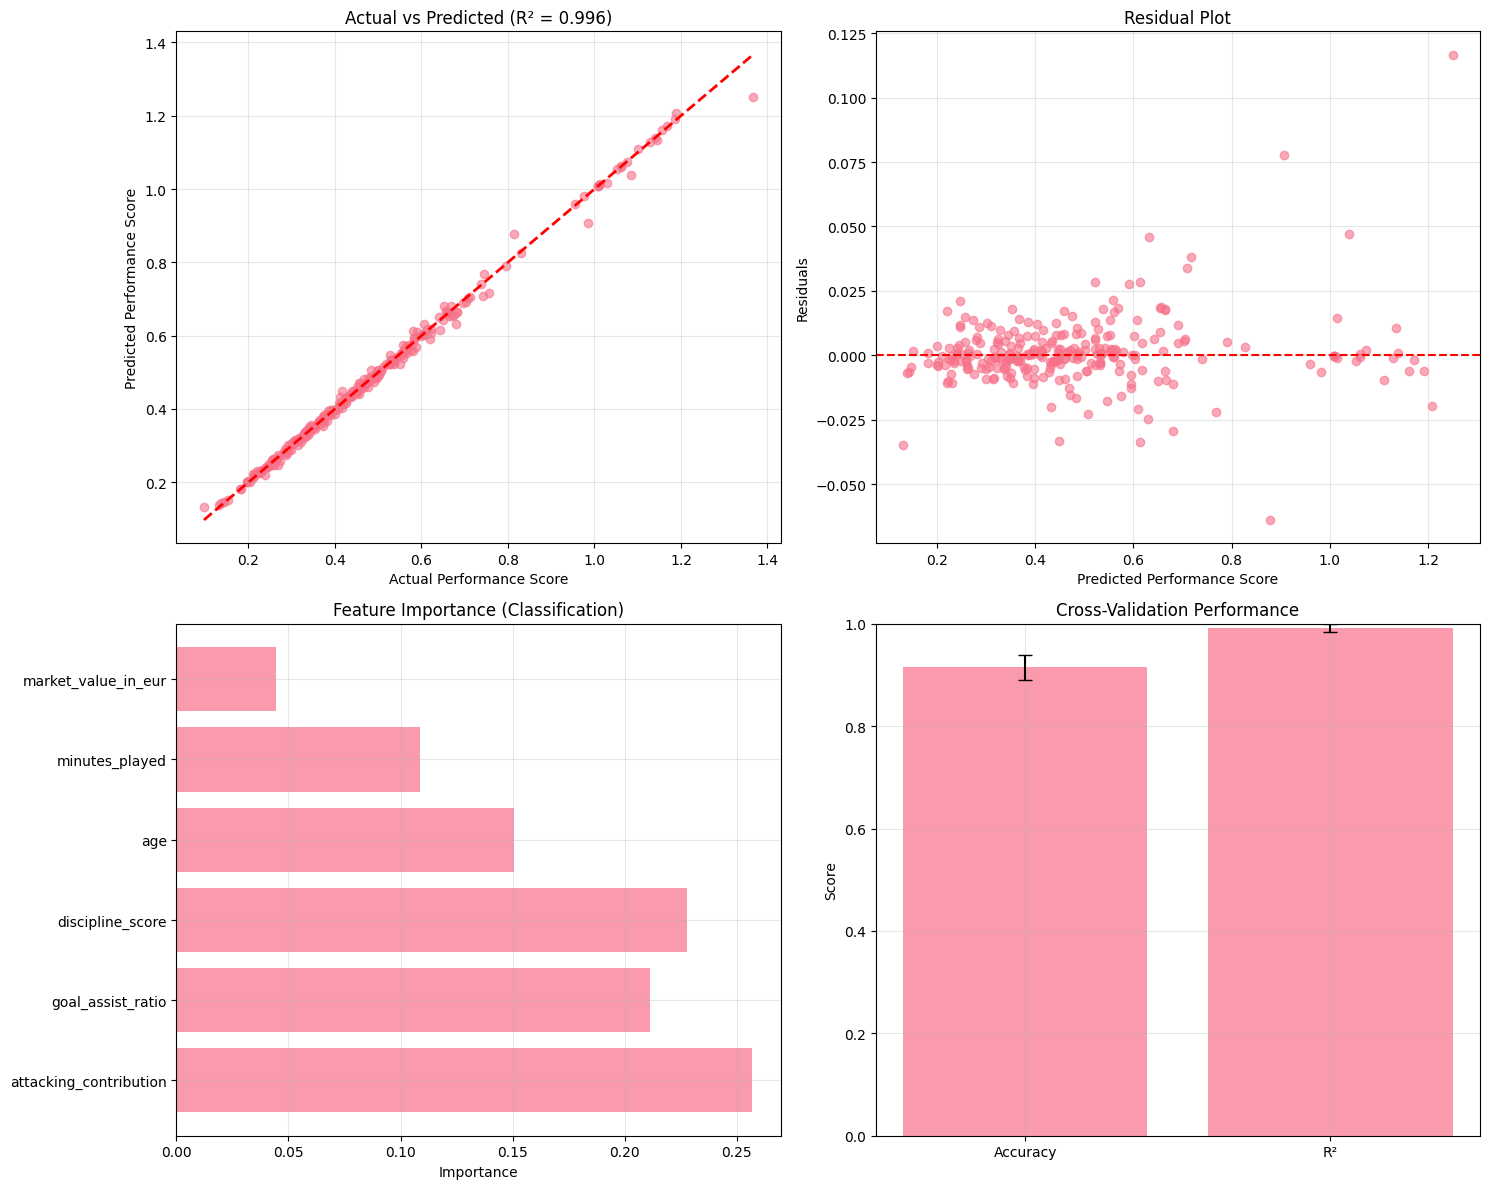


📋 MIDFIELDER MODEL ACCURACY SUMMARY

🎯 CLASSIFICATION PERFORMANCE:
   Accuracy:     0.9355 (93.55%)
   Precision:    0.9379 (93.79%)
   Recall:       0.9355 (93.55%)
   F1-Score:     0.9353 (93.53%)

🎯 REGRESSION PERFORMANCE:
   R²:           0.9963 (99.63%)
   RMSE:         0.013927
   MAE:          0.007800
   MAPE:         1.75%

🎯 CROSS-VALIDATION:
   Accuracy CV:  0.9153 (±0.0244)
   R² CV:        0.9915 (±0.0077)

🏆 OVERALL MODEL PERFORMANCE:
   Classification Score: 0.9360 (93.6%)
   Regression Score:     0.9963 (99.6%)
   Combined Score:       0.9662 (96.6%)
   Final Grade:          A+ (Outstanding)

✅ Evaluation complete!


In [25]:
# Midfielder Model - Standard Accuracy Metrics
# MSE, R², Accuracy, Precision, Recall, F1-Score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, mean_absolute_error,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import joblib
import seaborn as sns

print("📊 MIDFIELDER MODEL - STANDARD ACCURACY METRICS")
print("="*55)

# ================================
# 1. LOAD MODEL AND PREPARE DATA
# ================================

try:
    engine = joblib.load('midfielder_recommendation_engine.pkl')
    df = engine.df.copy()
    print(f"✅ Dataset loaded: {len(df)} players")
except:
    print("❌ Please run Parts 1-3 first!")
    exit()

# Prepare features and targets
features = [
    'attacking_contribution', 'goal_assist_ratio', 'discipline_score',
    'age', 'minutes_played', 'market_value_in_eur'
]

X = df[features]
y_classification = df['midfielder_role']  # For classification metrics
y_regression = df['performance_score']    # For regression metrics

print(f"✅ Features: {len(features)}")
print(f"✅ Classes: {y_classification.nunique()}")

# ================================
# 2. CLASSIFICATION ACCURACY METRICS
# ================================

print("\n🎯 CLASSIFICATION METRICS (Midfielder Type Prediction)")
print("-" * 55)

# Train-test split
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train_class)

# Make predictions
y_pred_class = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')
f1 = f1_score(y_test_class, y_pred_class, average='weighted')

print(f"📈 Accuracy Score:     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📈 Precision (Weighted): {precision:.4f} ({precision*100:.2f}%)")
print(f"📈 Recall (Weighted):    {recall:.4f} ({recall*100:.2f}%)")
print(f"📈 F1-Score (Weighted):  {f1:.4f} ({f1*100:.2f}%)")

# Cross-validation scores
cv_scores = cross_val_score(rf_classifier, X, y_classification, cv=5)
print(f"📈 Cross-Val Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"   Range: {cv_scores.min():.4f} - {cv_scores.max():.4f}")

# ================================
# 3. REGRESSION ACCURACY METRICS
# ================================

print("\n🎯 REGRESSION METRICS (Performance Score Prediction)")
print("-" * 55)

# Train-test split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = rf_regressor.predict(X_test_reg)

# Calculate regression metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

# Additional regression metrics
mape = np.mean(np.abs((y_test_reg - y_pred_reg) / y_test_reg)) * 100
residuals = y_test_reg - y_pred_reg
residual_std = np.std(residuals)

print(f"📈 R² Score (R-squared): {r2:.4f} ({r2*100:.2f}%)")
print(f"📈 Mean Squared Error:   {mse:.6f}")
print(f"📈 Root Mean Sq Error:   {rmse:.6f}")
print(f"📈 Mean Absolute Error:  {mae:.6f}")
print(f"📈 Mean Abs Percentage:  {mape:.2f}%")
print(f"📈 Residual Std Dev:     {residual_std:.6f}")

# Cross-validation for regression
cv_r2_scores = cross_val_score(rf_regressor, X, y_regression, cv=5, scoring='r2')
cv_mse_scores = -cross_val_score(rf_regressor, X, y_regression, cv=5, scoring='neg_mean_squared_error')

print(f"📈 Cross-Val R²:        {cv_r2_scores.mean():.4f} (±{cv_r2_scores.std():.4f})")
print(f"📈 Cross-Val MSE:       {cv_mse_scores.mean():.6f} (±{cv_mse_scores.std():.6f})")

# ================================
# 4. DETAILED CLASSIFICATION REPORT
# ================================

print("\n🎯 DETAILED CLASSIFICATION REPORT")
print("-" * 55)

print("\nClassification Report by Midfielder Type:")
print(classification_report(y_test_class, y_pred_class))

# ================================
# 5. CONFUSION MATRIX
# ================================

print("\n🎯 CONFUSION MATRIX")
print("-" * 55)

cm = confusion_matrix(y_test_class, y_pred_class)
labels = sorted(y_classification.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Midfielder Type Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ================================
# 6. FEATURE IMPORTANCE
# ================================

print("\n🎯 FEATURE IMPORTANCE")
print("-" * 55)

# Classification feature importance
class_importance = rf_classifier.feature_importances_
reg_importance = rf_regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Classification_Importance': class_importance,
    'Regression_Importance': reg_importance
})

feature_importance_df = feature_importance_df.sort_values('Classification_Importance', ascending=False)

print("Feature Importance (Classification):")
for _, row in feature_importance_df.iterrows():
    print(f"  {row['Feature']:<25}: {row['Classification_Importance']:.4f}")

print("\nFeature Importance (Regression):")
for _, row in feature_importance_df.sort_values('Regression_Importance', ascending=False).iterrows():
    print(f"  {row['Feature']:<25}: {row['Regression_Importance']:.4f}")

# ================================
# 7. MODEL PERFORMANCE VISUALIZATION
# ================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted (Regression)
ax1.scatter(y_test_reg, y_pred_reg, alpha=0.6)
ax1.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Performance Score')
ax1.set_ylabel('Predicted Performance Score')
ax1.set_title(f'Actual vs Predicted (R² = {r2:.3f})')
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2.scatter(y_pred_reg, residuals, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted Performance Score')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# Plot 3: Feature Importance Comparison
ax3.barh(features, class_importance, alpha=0.7, label='Classification')
ax3.set_xlabel('Importance')
ax3.set_title('Feature Importance (Classification)')
ax3.grid(True, alpha=0.3)

# Plot 4: Cross-validation scores
cv_metrics = ['Accuracy', 'R²']
cv_means = [cv_scores.mean(), cv_r2_scores.mean()]
cv_stds = [cv_scores.std(), cv_r2_scores.std()]

ax4.bar(cv_metrics, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
ax4.set_ylabel('Score')
ax4.set_title('Cross-Validation Performance')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================
# 8. SUMMARY REPORT
# ================================

print("\n" + "="*55)
print("📋 MIDFIELDER MODEL ACCURACY SUMMARY")
print("="*55)

print(f"\n🎯 CLASSIFICATION PERFORMANCE:")
print(f"   Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision:    {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:       {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:     {f1:.4f} ({f1*100:.2f}%)")

print(f"\n🎯 REGRESSION PERFORMANCE:")
print(f"   R²:           {r2:.4f} ({r2*100:.2f}%)")
print(f"   RMSE:         {rmse:.6f}")
print(f"   MAE:          {mae:.6f}")
print(f"   MAPE:         {mape:.2f}%")

print(f"\n🎯 CROSS-VALIDATION:")
print(f"   Accuracy CV:  {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"   R² CV:        {cv_r2_scores.mean():.4f} (±{cv_r2_scores.std():.4f})")

# Overall grade based on standard ML metrics
overall_class_score = (accuracy + precision + recall + f1) / 4
overall_reg_score = max(0, r2)  # R² can be negative, but we want 0 as minimum
overall_score = (overall_class_score + overall_reg_score) / 2

print(f"\n🏆 OVERALL MODEL PERFORMANCE:")
print(f"   Classification Score: {overall_class_score:.4f} ({overall_class_score*100:.1f}%)")
print(f"   Regression Score:     {overall_reg_score:.4f} ({overall_reg_score*100:.1f}%)")
print(f"   Combined Score:       {overall_score:.4f} ({overall_score*100:.1f}%)")

if overall_score >= 0.9:
    grade = "A+ (Outstanding)"
elif overall_score >= 0.8:
    grade = "A (Excellent)"
elif overall_score >= 0.7:
    grade = "B+ (Very Good)"
elif overall_score >= 0.6:
    grade = "B (Good)"
else:
    grade = "C (Satisfactory)"

print(f"   Final Grade:          {grade}")
print("\n✅ Evaluation complete!")